In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,Reshape, Flatten, Conv2DTranspose, Dense, ZeroPadding2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

In [2]:
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()
(x_train_fmnist, y_train_fmnist), (x_test_fmnist, y_test_fmnist) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Shape of train mnist dataset:  (60000, 28, 28)
Shape of test mnist dataset:  (10000, 28, 28)
Mnist sample image with label 5


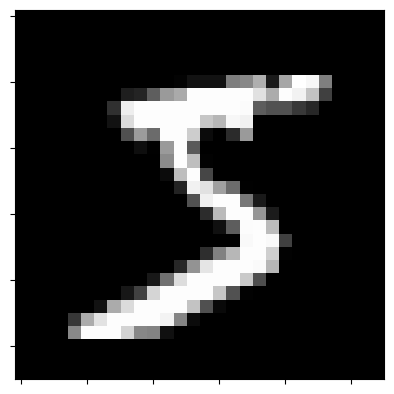

Shape of train fashion mnist dataset:  (60000, 28, 28)
Shape of test fashion mnist dataset:  (10000,)
Fashion Mnist sample image with label 9


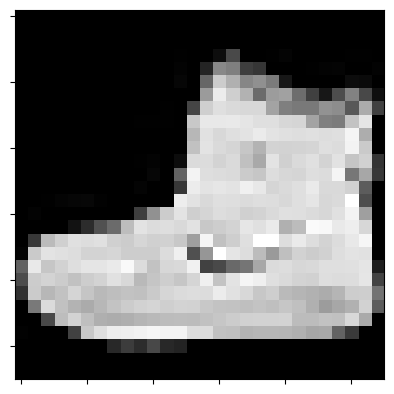

In [ ]:
print('Shape of train mnist dataset: ', x_train_mnist.shape)
print('Shape of test mnist dataset: ', x_test_mnist.shape)
print(f'Mnist sample image with label {y_train_mnist[0]}')
plt.xticks(visible = False)
plt.yticks(visible = False)
plt.imshow(x_train_mnist[0], cmap = 'gray')
plt.savefig('sample_mnist')
plt.show()
print('Shape of train fashion mnist dataset: ', x_train_fmnist.shape)
print('Shape of test fashion mnist dataset: ', y_test_fmnist.shape)
print(f'Fashion Mnist sample image with label {y_train_fmnist[0]}')
plt.xticks(visible = False)
plt.yticks(visible = False)
plt.imshow(x_train_fmnist[0], cmap = 'gray')
plt.savefig('sample_fmnist')
plt.show()

In [3]:
x_train_mnist = x_train_mnist.astype('float32') / 255.0
x_train_fmnist = x_train_fmnist.astype('float32') / 255.0
x_test_mnist = x_test_mnist.astype('float32') / 255.0
x_test_fmnist = x_test_fmnist.astype('float32') / 255.0

In [4]:
x_train_mnist, x_val_mnist, y_train_mnist, y_val_mnist = train_test_split(
    x_train_mnist, y_train_mnist, test_size=0.25, random_state=1)

x_train_fmnist, x_val_fmnist, y_train_fmnist, y_val_fmnist = train_test_split(
    x_train_fmnist, y_train_fmnist, test_size=0.25, random_state=1)

In [5]:
class Autoencoder:
    def __init__(self, train, test, val, latent = 5, epochs = 10, batch_size = 256, lr = 1e-3, opt = Adam):
        self.train = train
        self.test = test
        self.val = val
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.opt = opt
        self.encoder = self.encoder_maker(latent)
        self.decoder = self.decoder_maker(latent)
        print('Encoder Model: ', self.encoder.summary())
        print('Decoder Model: ', self.decoder.summary())
        self.model = Model(self.inp, self.decoder(self.latent))


    def encoder_maker(self, latent):
        inp = Input(shape = (28, 28, 1))
        self.inp = inp
        conv = Conv2D(16, (3, 3), activation = 'relu')(inp)
        pool = MaxPooling2D((2, 2))(conv)
        pool = BatchNormalization()(pool)
        conv = Conv2D(32, (3, 3), activation = 'relu')(pool)
        pool = MaxPooling2D((2, 2))(conv)
        pool = BatchNormalization()(pool)
        conv = Conv2D(64, (3, 3), activation = 'relu')(pool)
        pool = Flatten()(pool)
        dense = Dense(latent)(pool)
        self.latent = dense
        return Model(inp, dense)

    def decoder_maker(self, latent):
        inp_1= Input(shape = (latent,))
        dense = Dense(3 * 3 * 64, activation = 'relu')(inp_1)
        inp = Reshape((3, 3, 64))(dense)
        pad = ZeroPadding2D((1, 1))(inp)
        conv = Conv2DTranspose(32, 7, activation = 'relu')(pad)
        conv = BatchNormalization()(conv)
        pad = ZeroPadding2D((1, 1))(conv)
        conv = Conv2DTranspose(16, 14, activation = 'relu')(pad)
        conv = BatchNormalization()(conv)
        conv = Conv2DTranspose(1, 3, activation = 'relu')(conv)
        return Model(inp_1, conv)

    def train_model(self):
        optimizer = self.opt(learning_rate=self.lr)
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mae'])
        return self.model.fit(self.train[0], self.train[1], epochs = self.epochs, batch_size = self.batch_size, validation_data = (self.val[0], self.val[1]))

    def test_model(self):
        return self.model.evaluate(self.test[0], self.test[1], batch_size = self.batch_size)

    def predict(self, data):
        return self.model.predict(data)



In [ ]:
autoencoder_minst = Autoencoder((x_train_mnist, x_train_mnist), (x_test_mnist, x_test_mnist), (x_val_mnist, x_val_mnist))

Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 13, 13, 16)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_12 (Ba  (None, 13, 13, 16)        64        
 tchNormalization)                                               
                                                                 
 conv2d_46 (Conv2D)          (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 5, 5, 32)          0  

In [ ]:
history_mnist = autoencoder_minst.train_model()

Epoch 1/10
176/176 [==============================] - 18s 99ms/step - loss: 0.0711 - mse: 0.0711 - mae: 0.1279 - val_loss: 0.1093 - val_mse: 0.1093 - val_mae: 0.1309
Epoch 2/10
176/176 [==============================] - 17s 98ms/step - loss: 0.0434 - mse: 0.0434 - mae: 0.0921 - val_loss: 0.0726 - val_mse: 0.0726 - val_mae: 0.1104
Epoch 3/10
176/176 [==============================] - 17s 98ms/step - loss: 0.0365 - mse: 0.0365 - mae: 0.0823 - val_loss: 0.0401 - val_mse: 0.0401 - val_mae: 0.0858
Epoch 4/10
176/176 [==============================] - 17s 99ms/step - loss: 0.0336 - mse: 0.0336 - mae: 0.0780 - val_loss: 0.0334 - val_mse: 0.0334 - val_mae: 0.0776
Epoch 5/10
176/176 [==============================] - 18s 102ms/step - loss: 0.0320 - mse: 0.0320 - mae: 0.0755 - val_loss: 0.0317 - val_mse: 0.0317 - val_mae: 0.0753
Epoch 6/10
176/176 [==============================] - 18s 102ms/step - loss: 0.0308 - mse: 0.0308 - mae: 0.0738 - val_loss: 0.0310 - val_mse: 0.0310 - val_mae: 0.0735
Ep

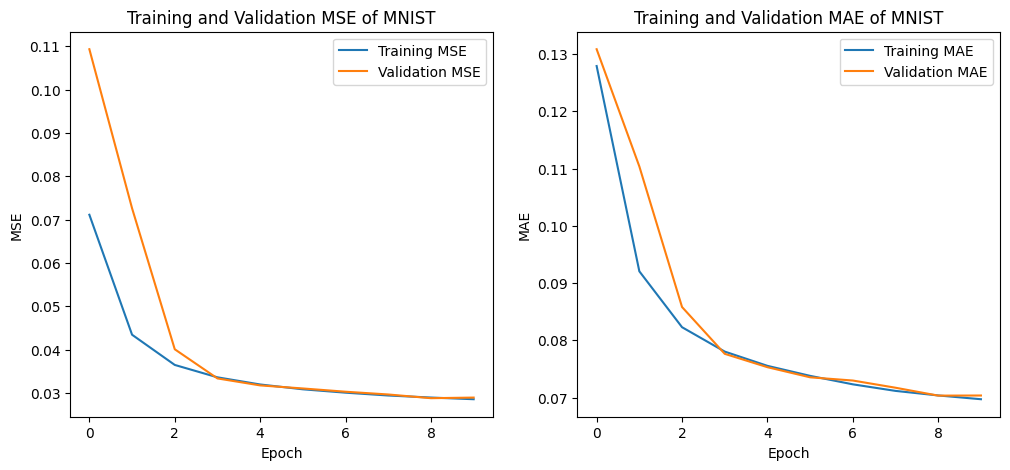

In [ ]:
# Extracting values
train_mse = history_mnist.history['mse']
val_mse = history_mnist.history['val_mse']
train_mae = history_mnist.history['mae']
val_mae = history_mnist.history['val_mae']

# Plot MSE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_mse, label='Training MSE')
plt.plot(val_mse, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation MSE of MNIST')
plt.savefig('MNIST_MSE')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE of MNIST')
plt.savefig('MNIST_MAE')
plt.legend()

plt.show()

In [ ]:
autoencoder_minst.test_model()

40/40 [==============================] - 1s 32ms/step - loss: 0.0288 - mse: 0.0288 - mae: 0.0702


[0.028820276260375977, 0.028820276260375977, 0.07022374868392944]

313/313 [==============================] - 2s 6ms/step


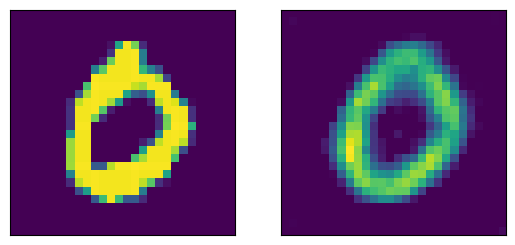

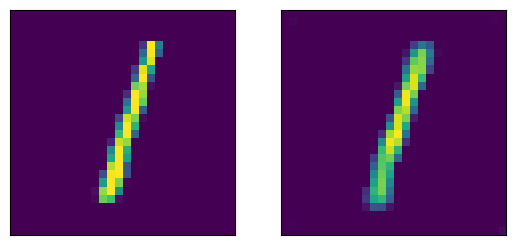

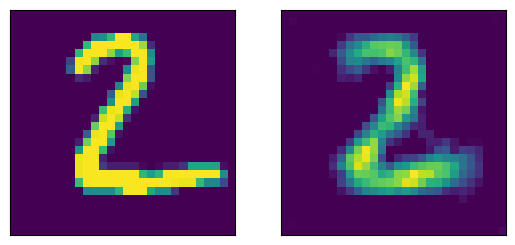

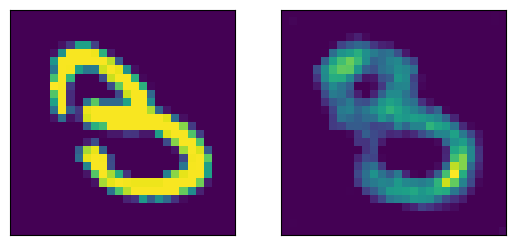

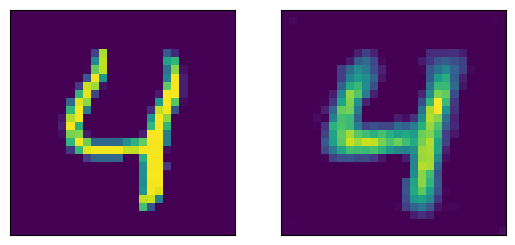

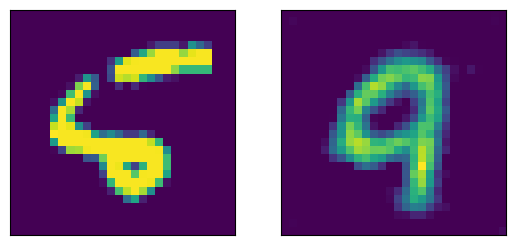

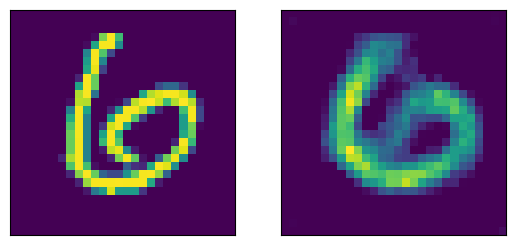

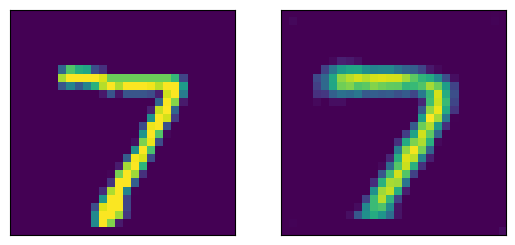

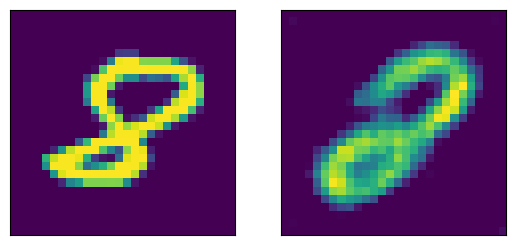

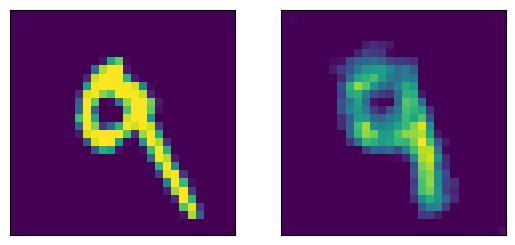

In [ ]:
res = autoencoder_minst.predict(x_test_mnist)
for i in range(10):
    for j in range(y_test_mnist.shape[0]):
        if y_test_mnist[j] == i:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(x_test_mnist[j])
            ax[1].imshow(res[j])
            ax[0].set_xticks([])
            ax[0].set_yticks([])
            ax[1].set_xticks([])
            ax[1].set_yticks([])
            plt.savefig(f'{i}_mnist')
            plt.show()
            break

In [6]:
autoencoder_fmnist = Autoencoder((x_train_fmnist, x_train_fmnist), (x_test_fmnist, x_test_fmnist), (x_val_fmnist, x_val_fmnist))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 13, 13, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0     

In [7]:
history_fmnist = autoencoder_fmnist.train_model()

Epoch 1/10
176/176 [==============================] - 16s 30ms/step - loss: 0.0863 - mse: 0.0863 - mae: 0.2030 - val_loss: 0.0972 - val_mse: 0.0972 - val_mae: 0.2438
Epoch 2/10
176/176 [==============================] - 3s 16ms/step - loss: 0.0420 - mse: 0.0420 - mae: 0.1255 - val_loss: 0.0644 - val_mse: 0.0644 - val_mae: 0.1873
Epoch 3/10
176/176 [==============================] - 3s 17ms/step - loss: 0.0353 - mse: 0.0353 - mae: 0.1116 - val_loss: 0.0386 - val_mse: 0.0386 - val_mae: 0.1246
Epoch 4/10
176/176 [==============================] - 3s 17ms/step - loss: 0.0327 - mse: 0.0327 - mae: 0.1053 - val_loss: 0.0322 - val_mse: 0.0322 - val_mae: 0.1042
Epoch 5/10
176/176 [==============================] - 3s 15ms/step - loss: 0.0313 - mse: 0.0313 - mae: 0.1020 - val_loss: 0.0312 - val_mse: 0.0312 - val_mae: 0.1018
Epoch 6/10
176/176 [==============================] - 3s 15ms/step - loss: 0.0305 - mse: 0.0305 - mae: 0.1000 - val_loss: 0.0302 - val_mse: 0.0302 - val_mae: 0.0983
Epoch 7/1

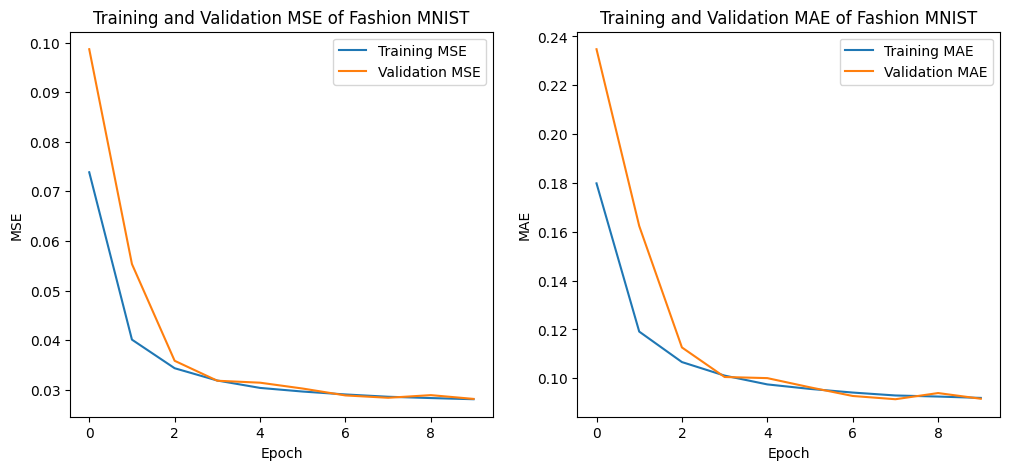

In [ ]:
# Extracting values
train_mse = history_fmnist.history['mse']
val_mse = history_fmnist.history['val_mse']
train_mae = history_fmnist.history['mae']
val_mae = history_fmnist.history['val_mae']

# Plot MSE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_mse, label='Training MSE')
plt.plot(val_mse, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.savefig('FMNIST_MSE')
plt.title('Training and Validation MSE of Fashion MNIST')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.savefig('FMNIST_MAE')
plt.title('Training and Validation MAE of Fashion MNIST')
plt.legend()

plt.show()

In [8]:
autoencoder_fmnist.test_model()

40/40 [==============================] - 0s 12ms/step - loss: 0.0280 - mse: 0.0280 - mae: 0.0938


[0.02800259180366993, 0.028002597391605377, 0.09377535432577133]

313/313 [==============================] - 1s 2ms/step


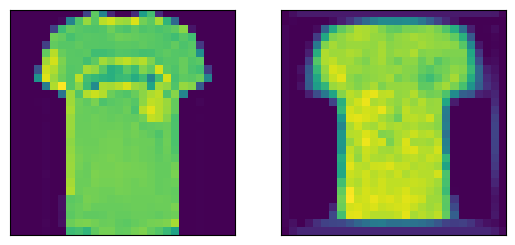

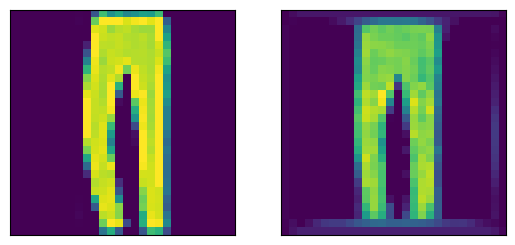

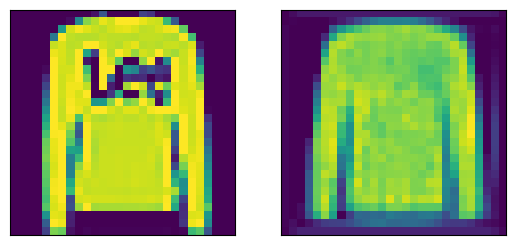

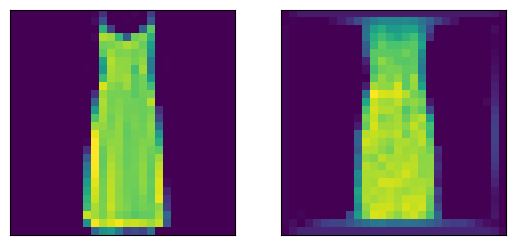

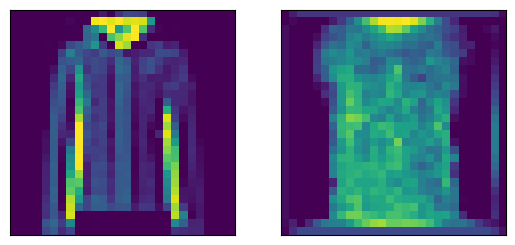

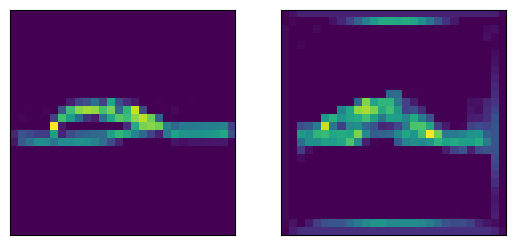

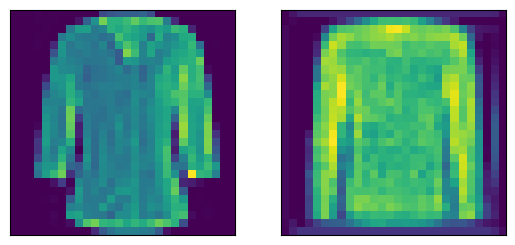

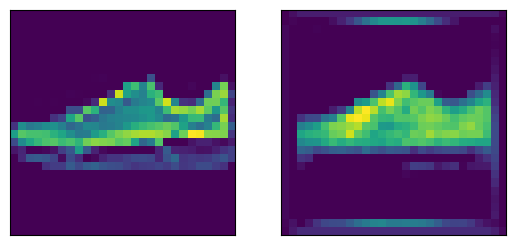

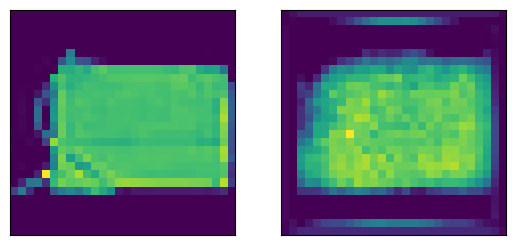

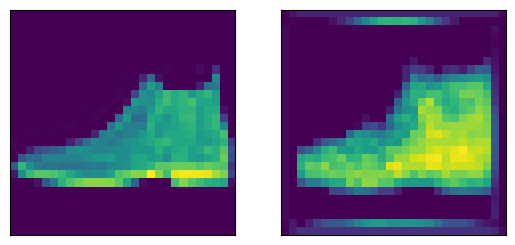

In [10]:
res = autoencoder_fmnist.predict(x_test_fmnist)
for i in range(10):
    for j in range(y_test_fmnist.shape[0]):
        if y_test_fmnist[j] == i:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(x_test_fmnist[j])
            ax[1].imshow(res[j])
            ax[0].set_xticks([])
            ax[0].set_yticks([])
            ax[1].set_xticks([])
            ax[1].set_yticks([])
            plt.savefig(f'{i}_fmnist')
            plt.show()
            break

In [ ]:
X_mnist = np.concatenate([x_train_mnist, x_test_mnist, x_val_mnist], axis=0)
X_fmnist = np.concatenate([x_train_fmnist, x_test_fmnist, x_val_fmnist], axis=0)
y_mnist = np.concatenate([y_train_mnist, y_test_mnist, y_val_mnist], axis=0)
y_fmnist = np.concatenate([y_train_fmnist, y_test_fmnist, y_val_fmnist], axis=0)

In [ ]:
mnist_encoder = autoencoder_minst.encoder
mnist_latent = mnist_encoder.predict(X_mnist)

2188/2188 [==============================] - 2s 883us/step


In [ ]:
scores = []
for i in range(5, 16):
    kmean = KMeans(i, random_state=1)
    labels = kmean.fit_predict(mnist_latent)
    scores.append(silhouette_score(mnist_latent, labels))
print('Best number of clusters for MNIST: ', np.argmax(scores) + 5)

/home/amirabbas/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/amirabbas/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/amirabbas/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/amirabbas/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 1

Best number of clusters for MNIST:  8


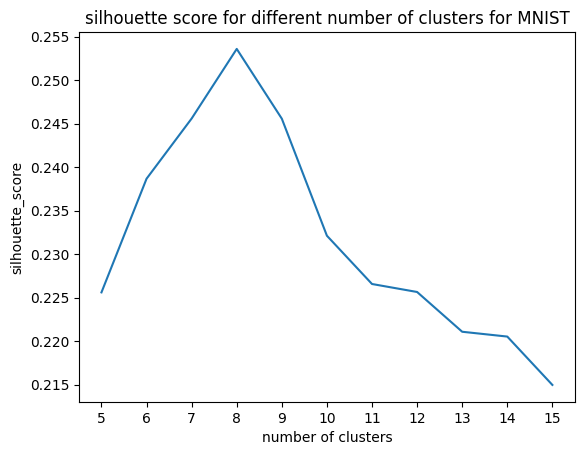

In [ ]:
plt.plot(range(5, 16), scores)
plt.xticks(range(5, 16))
plt.title('silhouette score for different number of clusters for MNIST')
plt.xlabel('number of clusters')
plt.ylabel('silhouette_score')
plt.show()

/home/amirabbas/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


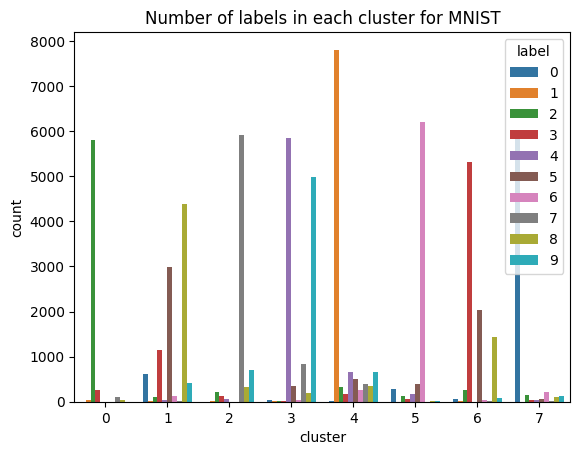

In [ ]:
kmean = KMeans(8, random_state=1)
mnist_labels = kmean.fit_predict(mnist_latent)
mnist_df = pd.DataFrame({'label': y_mnist, 'cluster': mnist_labels})
palette = sns.color_palette("tab10")
sns.countplot(data = mnist_df, x = 'cluster', hue = 'label', palette=palette)
plt.title('Number of labels in each cluster for MNIST')
plt.show()

In [ ]:
fmnist_encoder = autoencoder_fmnist.encoder
fmnist_latent = fmnist_encoder.predict(X_fmnist)

2188/2188 [==============================] - 3s 1ms/step


In [ ]:
scores = []
for i in range(5, 16):
    kmean = KMeans(i, random_state=1)
    labels = kmean.fit_predict(fmnist_latent)
    scores.append(silhouette_score(fmnist_latent, labels))
print('Best number of clusters for MNIST: ', np.argmax(scores) + 5)

/home/amirabbas/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/amirabbas/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/amirabbas/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/amirabbas/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 1

Best number of clusters for MNIST:  8


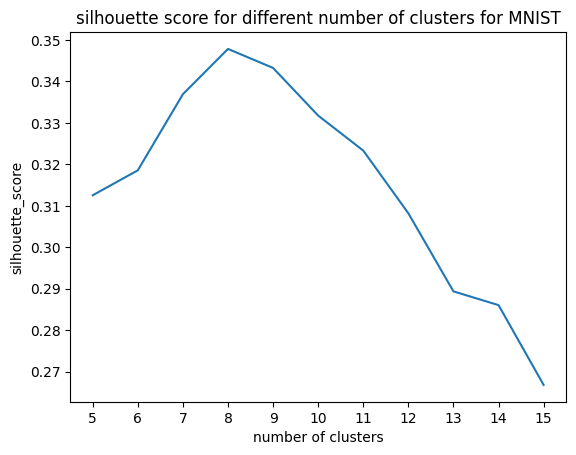

In [ ]:
plt.plot(range(5, 16), scores)
plt.xticks(range(5, 16))
plt.title('silhouette score for different number of clusters for MNIST')
plt.xlabel('number of clusters')
plt.ylabel('silhouette_score')
plt.savefig('silhouette_score_fmnist')
plt.show()

/home/amirabbas/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


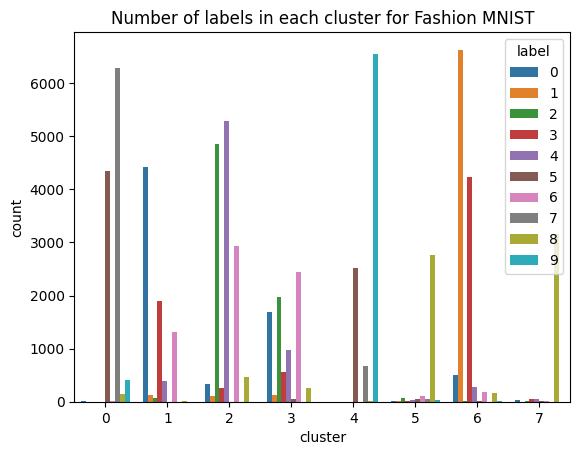

In [ ]:
fkmean = KMeans(8, random_state=1)
fmnist_labels = fkmean.fit_predict(fmnist_latent)
fmnist_df = pd.DataFrame({'label': y_fmnist, 'cluster': fmnist_labels})
palette = sns.color_palette("tab10")
sns.countplot(data = fmnist_df, x = 'cluster', hue = 'label', palette=palette)
plt.title('Number of labels in each cluster for Fashion MNIST')
plt.savefig('Feature_count_Fmnist')
plt.show()